In [225]:
import pandas as pd
from collections import OrderedDict,Counter
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler,label_binarize
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegressionCV,LogisticRegression
from sklearn.metrics import auc,balanced_accuracy_score,make_scorer,roc_auc_score,f1_score,roc_curve
from time import time
import seaborn as sns
from hyperopt import hp
from hyperopt.pyll.stochastic import sample
from hyperopt import STATUS_OK
from timeit import default_timer as timer
from hyperopt import Trials
from hyperopt import tpe
from hyperopt import fmin
import seaborn as sns
from sklearn.feature_selection import SelectFromModel,RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score,cross_val_predict
from scipy.spatial.distance import pdist, squareform,cdist
from scipy import exp
import lightgbm as gbm
from imblearn.over_sampling import SMOTE

In [2]:
import warnings
warnings.filterwarnings('ignore', category = RuntimeWarning)
plt.style.use('fivethirtyeight')
pd.options.display.max_columns = 150

In [155]:
train = pd.read_csv('training_set.csv')
train.head()

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,r4h3,r4m1,r4m2,r4m3,r4t1,r4t2,r4t3,tamviv,escolari,hhsize,cielorazo,elimbasu1,elimbasu2,elimbasu3,elimbasu4,elimbasu5,elimbasu6,dis,male,female,estadocivil1,estadocivil2,estadocivil3,estadocivil4,estadocivil5,estadocivil6,estadocivil7,parentesco1,parentesco2,parentesco3,parentesco4,parentesco5,parentesco6,parentesco7,parentesco8,parentesco9,parentesco10,parentesco11,parentesco12,idhogar,hogar_nin,hogar_adul,hogar_mayor,hogar_total,meaneduc,bedrooms,overcrowding,computer,television,mobilephone,qmobilephone,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,age,Target,dependency,rent-missing,wall_attrib,floor_attrib,roof_attrib,water_attrib,electric_attrib,sanitary_attrib,energy_attrib,wall_qual,roof_qual,floor_qual,edu_level,ownership_status,area,age_of_head,female_head,edu_head,prop_under_12,prop_adults,prop_elderly,mean_edu_child,mean_edu_teen,standard_of_living,house_quality,safe_waste_disposal
0,ID_279628684,190000.0,0,3,0,1,1,0,0.0,0,1,1,0,0,0,0,1,1,1,10,1,1,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,21eb7fcc1,0,1,0,1,10.0,1,1.000000,0,0,1,1,1,0,0,0,0,0,43,4,0.0,0,6,5,4,2,3,3,2,1,0,0,3,2,1,43,0,10,0.00,1.0,0.0,0.0,0.0,0.713333,0.375000,1
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,1,1,0,0,0,0,1,1,1,12,1,1,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0e5d7a658,0,1,1,1,12.0,1,1.000000,0,0,1,1,1,0,0,0,0,0,67,4,0.0,0,3,3,3,2,3,3,3,1,1,1,7,2,1,67,0,12,0.00,1.0,1.0,0.0,0.0,0.820000,0.437500,1
2,ID_68de51c94,0.0,0,8,0,1,1,0,0.0,0,0,0,0,1,1,0,1,1,1,11,1,1,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,2c7317ea8,0,1,1,1,11.0,2,0.500000,0,0,0,0,1,0,0,0,0,0,92,4,0.0,0,3,5,3,2,3,3,3,1,2,2,4,4,1,92,1,11,0.00,1.0,1.0,0.0,0.0,0.740000,0.645833,1
3,ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,0,2,2,1,1,2,1,3,4,4,9,4,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,2b58d945f,2,2,0,4,11.0,3,1.333333,0,0,1,3,1,0,0,0,0,0,17,4,1.0,0,6,5,3,2,3,3,3,2,2,2,3,2,1,38,0,11,0.25,0.5,0.0,2.0,9.0,0.820000,0.833333,1
4,ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,0,2,2,1,1,2,1,3,4,4,11,4,1,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2b58d945f,2,2,0,4,11.0,3,1.333333,0,0,1,3,1,0,0,0,0,0,37,4,1.0,0,6,5,3,2,3,3,3,2,2,2,4,2,1,38,0,11,0.25,0.5,0.0,2.0,9.0,0.820000,0.833333,1


In [156]:
test = pd.read_csv('testing_set.csv')
test.head()

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,r4h3,r4m1,r4m2,r4m3,r4t1,r4t2,r4t3,tamviv,escolari,hhsize,cielorazo,elimbasu1,elimbasu2,elimbasu3,elimbasu4,elimbasu5,elimbasu6,dis,male,female,estadocivil1,estadocivil2,estadocivil3,estadocivil4,estadocivil5,estadocivil6,estadocivil7,parentesco1,parentesco2,parentesco3,parentesco4,parentesco5,parentesco6,parentesco7,parentesco8,parentesco9,parentesco10,parentesco11,parentesco12,idhogar,hogar_nin,hogar_adul,hogar_mayor,hogar_total,meaneduc,bedrooms,overcrowding,computer,television,mobilephone,qmobilephone,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,age,dependency,rent-missing,wall_attrib,floor_attrib,roof_attrib,water_attrib,electric_attrib,sanitary_attrib,energy_attrib,wall_qual,roof_qual,floor_qual,edu_level,ownership_status,area,age_of_head,female_head,edu_head,prop_under_12,prop_adults,prop_elderly,mean_edu_child,mean_edu_teen,standard_of_living,house_quality,safe_waste_disposal
0,ID_2f6873615,0.0,0,5,0,1,1,0,0.0,1,1,2,0,1,1,1,2,3,3,0,3,1,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,72958b30c,1,2,0,3,16.500000,2,1.5,1,0,1,2,1,0,0,0,0,0,4,0.5,0,6,5,3,2,3,3,2,2,2,2,0,4,1,41,0,17,0.333333,0.666667,0.0,0.0,0.0,0.753333,0.833333,1
1,ID_1c78846d2,0.0,0,5,0,1,1,0,0.0,1,1,2,0,1,1,1,2,3,3,16,3,1,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,72958b30c,1,2,0,3,16.500000,2,1.5,1,0,1,2,1,0,0,0,0,0,41,0.5,0,6,5,3,2,3,3,2,2,2,2,7,4,1,41,0,17,0.333333,0.666667,0.0,0.0,0.0,0.753333,0.833333,1
2,ID_e5442cf6a,0.0,0,5,0,1,1,0,0.0,1,1,2,0,1,1,1,2,3,3,17,3,1,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,72958b30c,1,2,0,3,16.500000,2,1.5,1,0,1,2,1,0,0,0,0,0,41,0.5,0,6,5,3,2,3,3,2,2,2,2,8,4,1,41,1,17,0.333333,0.666667,0.0,0.0,0.0,0.753333,0.833333,1
3,ID_a8db26a79,0.0,0,14,0,1,1,1,1.0,0,1,1,0,0,0,0,1,1,1,16,1,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5b598fbc9,0,1,0,1,16.000000,1,1.0,1,0,1,2,1,0,0,0,0,0,59,0.0,0,6,5,3,2,3,3,3,2,2,2,7,4,1,59,0,16,0.000000,1.000000,0.0,0.0,0.0,0.860000,0.833333,1
4,ID_a62966799,175000.0,0,4,0,1,1,1,1.0,0,0,0,0,1,1,0,1,1,1,11,1,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1e2fc704e,1,0,0,1,9.158261,2,0.5,0,0,1,1,1,0,0,0,0,0,18,0.0,0,6,5,3,2,3,3,3,1,2,2,4,2,1,18,1,11,0.000000,0.000000,0.0,0.0,11.0,0.820000,0.708333,1


In [157]:
drop_columns = ['age_of_head','elimbasu1','elimbasu2','elimbasu3','elimbasu4','elimbasu5','elimbasu6','estadocivil1','estadocivil2','estadocivil3','estadocivil4','estadocivil5','estadocivil6','estadocivil7','parentesco2','parentesco3','parentesco4','parentesco5','parentesco6','parentesco7','parentesco8','parentesco9','parentesco10','parentesco11','parentesco12']

In [158]:
train.drop(drop_columns,axis=1,inplace=True)
test.drop(drop_columns,axis=1,inplace=True)

In [159]:
train.drop('female',axis=1,inplace=True)
test.drop('female',axis=1,inplace=True)

In [160]:
train_head = train[train.parentesco1 == 1].reset_index(drop=True)

In [161]:
train_head.head()

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,r4h3,r4m1,r4m2,r4m3,r4t1,r4t2,r4t3,tamviv,escolari,hhsize,cielorazo,dis,male,parentesco1,idhogar,hogar_nin,hogar_adul,hogar_mayor,hogar_total,meaneduc,bedrooms,overcrowding,computer,television,mobilephone,qmobilephone,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,age,Target,dependency,rent-missing,wall_attrib,floor_attrib,roof_attrib,water_attrib,electric_attrib,sanitary_attrib,energy_attrib,wall_qual,roof_qual,floor_qual,edu_level,ownership_status,area,female_head,edu_head,prop_under_12,prop_adults,prop_elderly,mean_edu_child,mean_edu_teen,standard_of_living,house_quality,safe_waste_disposal
0,ID_279628684,190000.0,0,3,0,1,1,0,0.0,0,1,1,0,0,0,0,1,1,1,10,1,1,0,1,1,21eb7fcc1,0,1,0,1,10.0,1,1.000000,0,0,1,1,1,0,0,0,0,0,43,4,0.0,0,6,5,4,2,3,3,2,1,0,0,3,2,1,0,10,0.00,1.0,0.0,0.0,0.0,0.713333,0.375000,1
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,1,1,0,0,0,0,1,1,1,12,1,1,0,1,1,0e5d7a658,0,1,1,1,12.0,1,1.000000,0,0,1,1,1,0,0,0,0,0,67,4,0.0,0,3,3,3,2,3,3,3,1,1,1,7,2,1,0,12,0.00,1.0,1.0,0.0,0.0,0.820000,0.437500,1
2,ID_68de51c94,0.0,0,8,0,1,1,0,0.0,0,0,0,0,1,1,0,1,1,1,11,1,1,1,0,1,2c7317ea8,0,1,1,1,11.0,2,0.500000,0,0,0,0,1,0,0,0,0,0,92,4,0.0,0,3,5,3,2,3,3,3,1,2,2,4,4,1,1,11,0.00,1.0,1.0,0.0,0.0,0.740000,0.645833,1
3,ID_ec05b1a7b,180000.0,0,5,0,1,1,1,1.0,0,2,2,1,1,2,1,3,4,4,11,4,1,0,1,1,2b58d945f,2,2,0,4,11.0,3,1.333333,0,0,1,3,1,0,0,0,0,0,38,4,1.0,0,6,5,3,2,3,3,3,2,2,2,4,2,1,0,11,0.25,0.5,0.0,2.0,9.0,0.820000,0.833333,1
4,ID_1284f8aad,130000.0,1,2,0,1,1,0,0.0,0,1,1,2,1,3,2,2,4,4,9,4,1,0,1,1,d6dae86b7,2,2,0,4,10.0,1,4.000000,0,0,1,1,1,0,0,0,0,0,30,4,1.0,0,6,5,3,2,3,3,2,0,0,1,3,2,1,0,9,0.50,0.5,0.0,1.5,0.0,0.713333,0.354167,1


In [162]:
train_head.shape

(2972, 70)

In [163]:
test.shape

(23851, 69)

In [172]:
submissions = pd.DataFrame({'Target':0},index=test['Id'])

In [197]:
train_head.drop(['Id','idhogar'],axis=1,inplace=True)
test.drop(['Id','idhogar'],axis=1,inplace=True)

In [198]:
feat_cols = train_head.columns.difference(['Target'])
train_feat = train_head[feat_cols].values

In [199]:
#scaling the features to have 0 mean and unit variance

In [200]:
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_feat)
test_scaled = scaler.fit_transform(test)

C:\Users\farazz\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\farazz\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [228]:
features = train_scaled
labels = train_head['Target']

### oversampling the dataset using SMOTE to upsample the minority class

In [ ]:
sm = SMOTE(ratio='all',k_neighbors=10)
X_resampled,Y_resampled = sm.fit_sample(features,labels)

In [229]:
Counter(labels)

Counter({4: 1953, 2: 442, 3: 355, 1: 222})

In [230]:
#number of samples in each class after SMOTE
Counter(Y_resampled)

Counter({4: 1953, 2: 1953, 3: 1953, 1: 1953})

### lets try to visualize our data using TSNE and investigate if the classes look seperable

tsne with perplexity 5 completed in 2.3896994670232137 min
tsne with perplexity 30 completed in 2.790892692406972 min
tsne with perplexity 50 completed in 3.375744394461314 min
tsne with perplexity 100 completed in 3.529277741909027 min


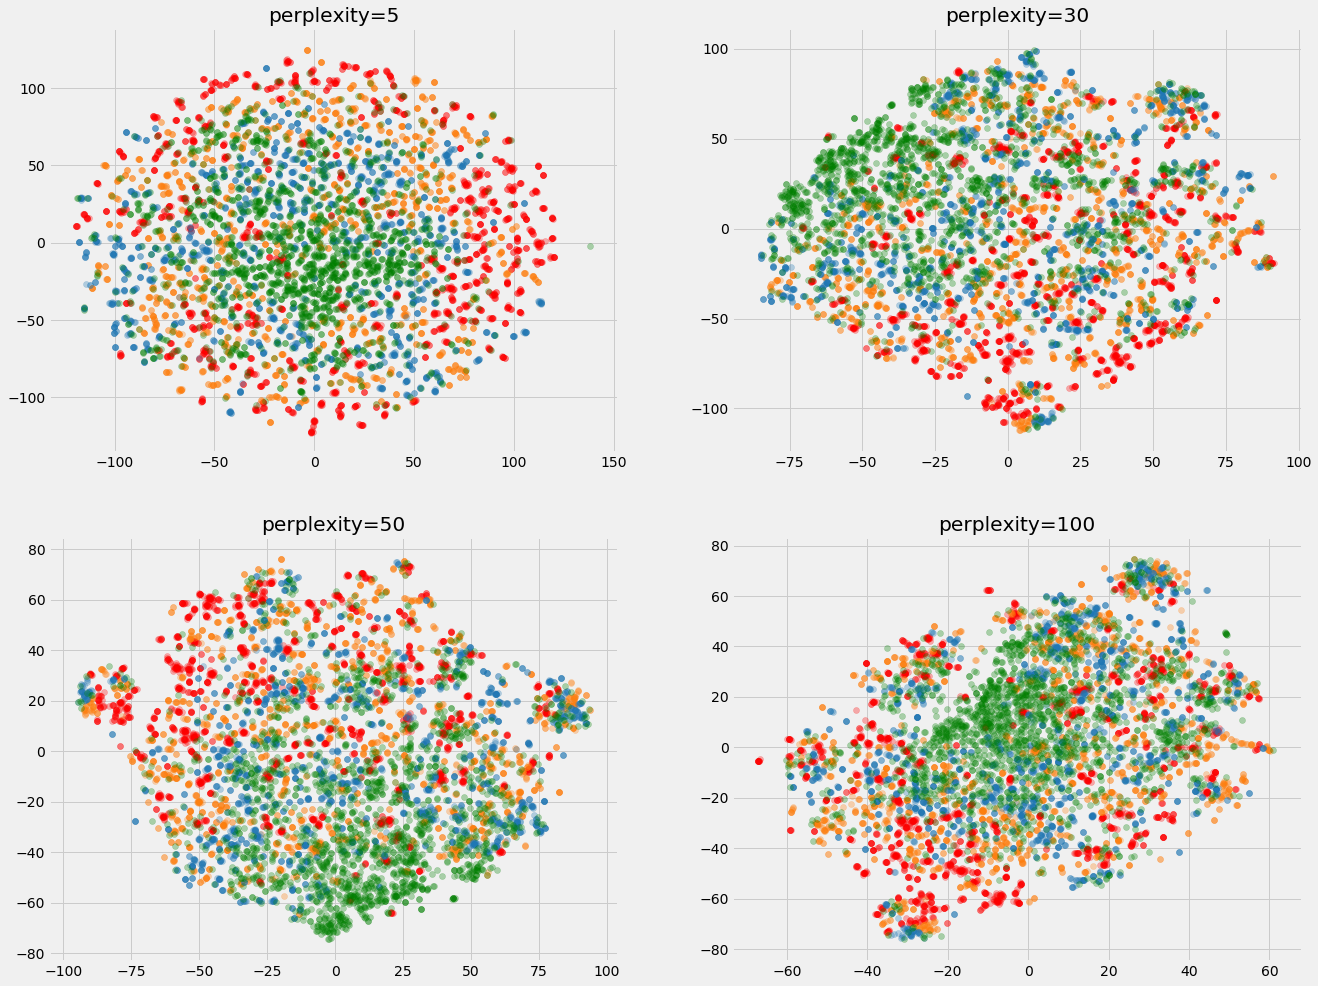

In [206]:
perplexities = [5,30,50,100]
targets = [1,2,3,4]
labels = ['extreme','moderate','vulnerable','non-vulnerable']
colors = ['r','tab:orange','tab:blue','g']
plt.figure(figsize = (20, 16))
for i,perplexity in enumerate(perplexities):
    ax = plt.subplot(2,2,i+1)
    t0 = time()
    tsne_embedding = TSNE(n_components=2,perplexity=perplexity)
    embedding = tsne_embedding.fit_transform(X_resampled)
    t1 = time()
    print('tsne with perplexity {} completed in {} min'.format(perplexity,(t1-t0)/60))
    tsne_result = pd.DataFrame({'X':embedding[:,0],'Y':embedding[:,1],'target':Y_resampled})
    for target,label,color in [(targets[i],labels[i],colors[i]) for i in range(0,4)]:
        ax.scatter(x=tsne_result['X'][tsne_result.target == target].values,y=tsne_result['Y'][tsne_result.target == target].values,color= color,label=\
        label,alpha=0.3)
    plt.title('perplexity={}'.format(perplexity))


As we can observe from the plots for TSNE performed on the dataset and TSNE performed on the reduced set of features using PCA,the shape of the original data shows some degree of separability.
But,from the visualizations we see after performing PCA and then TSNE,we see that the classes are clumped together.
We cannot be conclusive about the separablity from these plots but it can give us some idea about the next steps or algorithms we should consider for our classification task.

## logistic regression with bayesian optimization

In [231]:
## We'll start with logistic regression and use our unsampled dataset and assess the preformance

### we require 4 components to implement bayesian optimization
#### 1.The objective function
#### 2.the domain space
#### 3.Hyperparameter optimization algorithm
#### 4.History of results

### we'll first start by initializing the domain space,which are the values for different parameters to be used in logistic regression like penalty,solver and regularization
#### It should be initialized as a dictionary with parameter names as keys and their respective search space as values

In [17]:
space = {'C':hp.uniform('C', 0.001, 100),
         'penalty':hp.choice('penalty',[{'penalty':'l1','solver':'saga'},
                                        {'penalty':'l2','solver':'sag'}]),
         'class_weight':hp.choice('class_weight',[None,'balanced'])}

#### helper functions to calculate average roc ,making roc_auc scorer function to pass it to our estimator and compare distributions after optimization

In [121]:
def avg_roc(multi_class_scores):
    result = list()
    for i in range(1,5):
        roc_class = np.ravel(multi_class_scores[i])
        result.append(np.mean(np.ravel(roc_class)))
    avg_roc = np.mean(result)
    print('average roc-auc value for each class')
    print('-' * 50)
    poverty_level = {1:'extreme',2:'moderate',3:'vulnerable',4:'non-vulnerable'}
    for i in range(0,4):
        print(poverty_level[i+1],' class--',result[i])
    print('-' * 50)
    print('overall average roc-auc value-{}'.format(np.round(avg_roc,3)))
    
def plot_ROC(fpr,tpr,n_classes):
    
    colors = ['red', 'yellow', 'blue','green']
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=1.0,
                 label='ROC of class {0} (area = {1:0.2f})'
                 ''.format(i+1, roc_auc[i]))
    plt.plot([0, 1], [0, 1], 'k--', lw=0.25)
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="best")
    plt.show()

def compare_distributions(param):
    uniform_C = list()
    for i in range(0,200):
        x = sample(space)
        uniform_C.append(x[param])

    sns.kdeplot(uniform_C, label = 'uniform-dist')
    sns.kdeplot(results[param], label = 'Bayes Optimization')
    plt.legend(loc = 'best')
    plt.title('{} Distribution'.format(param))
    plt.xlabel('{}'.format(param)); plt.ylabel('Density');
    plt.show();

def roc_auc_score_proba(y_true, proba):
    return roc_auc_score(y_true, proba[:, 1])

# define your scorer
roc_auc_weighted = make_scorer(roc_auc_score, average='weighted')


#### Defining an objective function

In [20]:
N_FOLDS = 5
def LR_objective(params,num_folds = N_FOLDS):
    
    global ITERATION
    
    ITERATION += 1
    
    penalty = params['penalty']['penalty']
    solver = params['penalty']['solver']
    class_weight = params['class_weight']
    reg = float(params['C'])
    
    start = timer()
    
    lg_cv = LogisticRegressionCV(Cs=[reg],multi_class='ovr',class_weight=class_weight,cv=num_folds,penalty=penalty,solver=solver,scoring=roc_auc_weighted,max_iter=1000)
    lg_cv.fit(features,labels)
    
    runtime = timer() - start
    
    roc_auc = avg_roc(lg_cv.scores_)
    
    loss = 1 - roc_auc
    
    return {'loss': loss, 'params': params, 'iteration': ITERATION,
            'train_time': runtime, 'status': STATUS_OK}
    
    
    

#### optimization algorithm

In [17]:
tpe_algorithm = tpe.suggest

#### Result history

In [132]:
bayes_trials = Trials()

#### All the 4 components are defined,the final step is to minimize the objective function

In [133]:
%%capture

# Global variable
global  ITERATION

ITERATION = 0

MAX_EVALS = 100
start = timer()
best = fmin(fn = LR_objective, space = space, algo = tpe_algorithm, 
            max_evals = MAX_EVALS, trials = bayes_trials, rstate = np.random.RandomState(50))
runtime = timer() - start

In [188]:
print('total runtime to minimize:{} min'.format(round(runtime/60)))

total runtime to minimize:73 min


In [183]:
#We would be storing the results from all the iterations for analysis
bayes_trials_results = bayes_trials.results

In [199]:
#creating a results dataframe
dt = sorted([{'loss':trial['loss'],'C':trial['params']['C'],'class_weight':trial['params']['class_weight'],\
      'penalty':trial['params']['penalty']['penalty'],'train_time':trial['train_time']} for trial in bayes_trials_results],key=lambda x:(x['loss'],x['train_time']))
results = pd.DataFrame(dt)
results.head()

,C,class_weight,loss,penalty,train_time
0,12.791454,balanced,0.444,l2,31.201272
1,13.387496,balanced,0.444,l2,31.473273
2,10.819931,balanced,0.444,l2,31.956855
3,11.206249,balanced,0.444,l2,32.360945
4,21.704616,balanced,0.444,l2,32.885560


average iteration-time:43.9 s


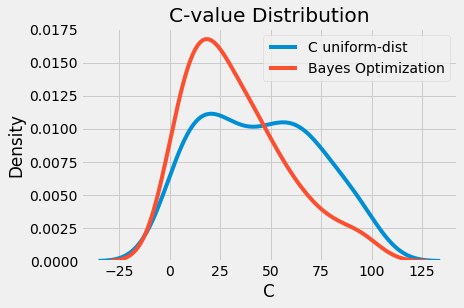

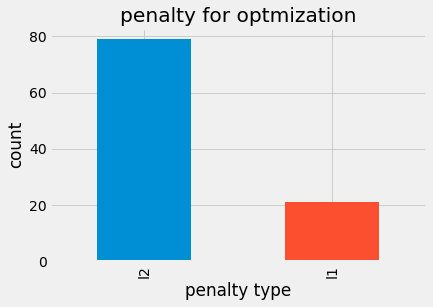

In [212]:
#average iteration runtime
avg_iteration_time = np.round(results.train_time.mean(),2)
print('average iteration-time:{} s'.format(avg_iteration_time))
#comparison of uniform C values and C values considered during optimization
compare_distributions('C')
#penalty chosen for optimization
results['penalty'].value_counts().plot.bar()
plt.title('penalty for optmization')
plt.xlabel('{}'.format('penalty type')); plt.ylabel('count');
plt.show();

#### let's take the values suggested by the optmization algorithm and use it in our logistic regression algorithm

In [152]:
lr = LogisticRegressionCV(penalty='l2',Cs=[12.79],multi_class='ovr',cv=5,scoring=roc_auc_weighted,class_weight='balanced',solver='sag',max_iter=2000,n_jobs=-1)
lr.fit(features,labels)

LogisticRegressionCV(Cs=[12.79], class_weight='balanced', cv=5, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=2000,
           multi_class='ovr', n_jobs=-1, penalty='l2', random_state=None,
           refit=True,
           scoring=make_scorer(roc_auc_score, average=weighted),
           solver='sag', tol=0.0001, verbose=0)

In [227]:
#auc scores after cross validation on training data
avg_roc(lr.scores_)

average roc-auc value for each class
--------------------------------------------------
extreme  class-- 0.5709646943986891
moderate  class-- 0.5236220491685206
vulnerable  class-- 0.5119856342364717
non-vulnerable  class-- 0.6144495976112091
--------------------------------------------------
overall average roc-auc value-0.555


#### As per the results,the roc-auc score is just slightly better than a guess and the overall score reflects this as well.
#### I see three reasons that might be causing a problem which could be:

 1.high dimensionality of the dataset,although we used l2 regression to bring down the importance or the coefficients of features not helping the algorithm seperate the classes.

 2.As per the TSNE visualizations,we observed that the classes are not seperable and classes like vulnerable,non-vulnerable do not have much difference between them.This could be addressed by using better algorithms like SVM or tree based methods which might do a better job in differentiating the classes

 3.The classes are highly imbalanced,and this could be proving to be a bottleneck as the minority classes do not have enough samples to help the algorithm/classifier learn from them.


## SVM Classifier

In [256]:
# we would now proceed to using the SVM classifier 
# we would also be using our upsampled data as well to see if we see an increase in performance.
# which provides us with the advantage of using kernels to address the inseperability problem between our classes.

In [19]:
def build_gauss_kernel(X1,X2,gamma):
    pairwise_dists = cdist(X1, X2, 'sqeuclidean')
    K = exp(-pairwise_dists ** 2 / gamma ** 2)
    return K

#### domain space

In [126]:
num_features = features.shape[1]
gamma_max = 1/(num_features * features.std())
space = {'C':hp.uniform('C',0.0001,1000),
         'gamma':hp.uniform('gamma',0,gamma_max),
         'kernel':hp.choice('kernel',['rbf','poly','sigmoid','gaussian'])}

#### objective function

In [119]:
NUM_FOLDS=5
def SVC_objective(params,num_folds=NUM_FOLDS):
    y_bin = label_binarize(labels, classes=[1,2,3,4])
    n_classes = y_bin.shape[1]
    global ITERATION
    ITERATION += 1
    
    gamma = params['gamma']
    reg = float(params['C'])
    kernel = params['kernel']
    
    if kernel == 'gaussian':
        gaussian_kernel = partial(build_gauss_kernel,gamma=gamma)
        svc = SVC(C=reg,kernel=gaussian_kernel,class_weight='balanced',decision_function_shape='ovr',probability=True)
    else :
        svc = SVC(C=reg,kernel=kernel,gamma=gamma,class_weight='balanced',decision_function_shape='ovr',probability=True)
    
    start = timer()

    y_score = cross_val_predict(svc,features,labels,cv=5,method='predict_proba')
    
    runtime = timer() - start

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    roc_auc_score = np.mean(list(roc_auc.values()))
    
    loss = 1 - roc_auc_score
    
    return {'loss': loss, 'params': params, 'iteration': ITERATION,
            'train_time': runtime, 'status': STATUS_OK}
    

#### optmization algorithm

In [120]:
tpe_algorithm = tpe.suggest

#### result history

In [121]:
svc_bayes_trials = Trials()

#### minimizing the objective function

In [140]:
%%capture

# Global variable
global  ITERATION

ITERATION = 0

MAX_EVALS = 200
start = timer()
best = fmin(fn = SVC_objective, space = space, algo = tpe_algorithm, 
            max_evals = MAX_EVALS, trials = svc_bayes_trials, rstate = np.random.RandomState(50))
runtime = timer() - start

In [142]:
print('total runtime to minimize:{} min'.format(round(runtime/60)))

total runtime to minimize:37 min


#### storing and converting the results to dataframe for analysis

In [143]:
#storing the results
bayes_trials_results = svc_bayes_trials.results
#converting the results to dataframe
dt = sorted([{'loss':trial['loss'],'C':trial['params']['C'],'kernel':trial['params']['kernel'],'gamma':trial['params']['gamma'],'train_time':trial['train_time']} for trial in bayes_trials_results],key=lambda x:(x['loss'],x['train_time']))
results = pd.DataFrame(dt)
results.head()

,C,gamma,kernel,loss,train_time
0,167.390350,0.000836,poly,0.266251,24.421899
1,92.463749,0.001022,poly,0.268408,24.824989
2,21.116578,0.001729,poly,0.268620,26.777247
3,84.898361,0.000820,poly,0.269127,25.233917
4,33.463773,0.001705,poly,0.270390,24.165656


In [131]:
# lets see what the optimization algorithm selected in the evaluations

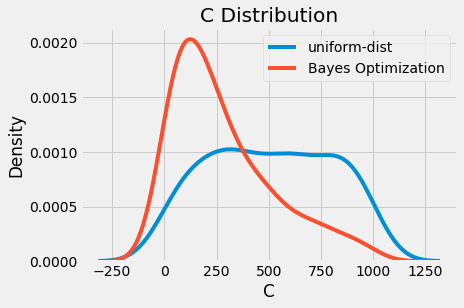

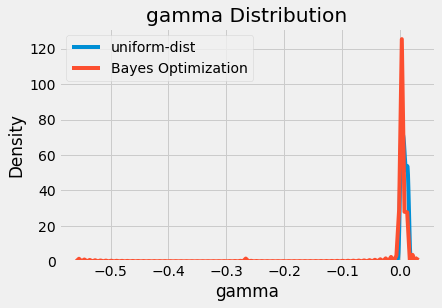

In [145]:
compare_distributions('C')
compare_distributions('gamma')

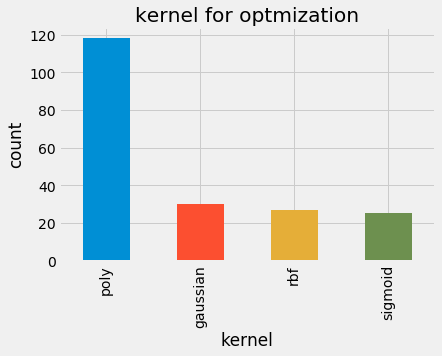

In [146]:
results['kernel'].value_counts().plot.bar()
plt.title('kernel for optmization')
plt.xlabel('{}'.format('kernel')); plt.ylabel('count');
plt.show();

#### As per the results,SVM with poly kernel gave the lowest loss which suggests that the decision boundary of our classes is nonlinear
#### However, this could be a case of overfitting as well.We need to verify the performance on the test set as well.

In [194]:
C = 167.39
kernel = 'poly'
gamma = 0.001
y_bin = label_binarize(Y_resampled, classes=[1,2,3,4])
n_classes = y_bin.shape[1]

svc = SVC(C=C,kernel=kernel,gamma=gamma,class_weight='balanced',decision_function_shape='ovr',probability=True)
    
y_score = cross_val_predict(svc,X_resampled,Y_resampled,cv=5,method='predict_proba')

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
print(roc_auc)
roc_auc_score = np.mean(list(roc_auc.values()))
print(roc_auc_score)

{0: 0.8613484473451769, 1: 0.8016548997009166, 2: 0.7981637433432025, 3: 0.7898870600256392}
0.8127635376037338


### ROC-AUC metrics on cross validated data

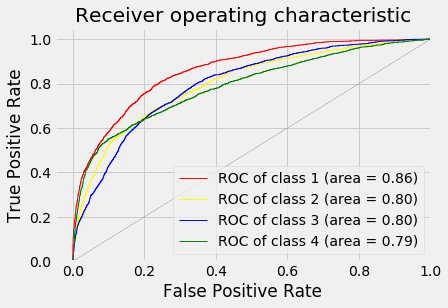

In [195]:
plot_ROC(fpr,tpr,n_classes=4)

#### we can see that the AUC for class 3 is low compared to the other three classes

## Light GBM

#### we would now be using lightgbm for classification and tune the hyperparameters using bayesian optmization.
#### we would be following the same process of setting up the domain space,defining the objective function and analysing the results and the choice of hyperparameters.

In [57]:
#creating the dataset to be used in LightGBM
feature_names = list(train_head.columns.difference(['Target']))
train_set = gbm.Dataset(features, label = labels,feature_name=feature_names)

In [19]:
feature_names = list(train_head.columns.difference(['Target']))

In [52]:
clf = gbm.LGBMClassifier(boosting_type='dart',class_weight='balanced',n_estimators=500,objective='multiclass',importance_type='gain')

In [75]:
score = cross_val_predict(clf,features,labels,cv=5,method='predict_proba')

In [81]:
y_bin = label_binarize(labels, classes=[1,2,3,4])
n_classes = y_bin.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
print(roc_auc)
roc_auc_score = np.mean(list(roc_auc.values()))
print(roc_auc_score)

{0: 0.6088632268632268, 1: 0.5634548316133994, 2: 0.5333663424951697, 3: 0.6260211134376192}
0.5829263786023537


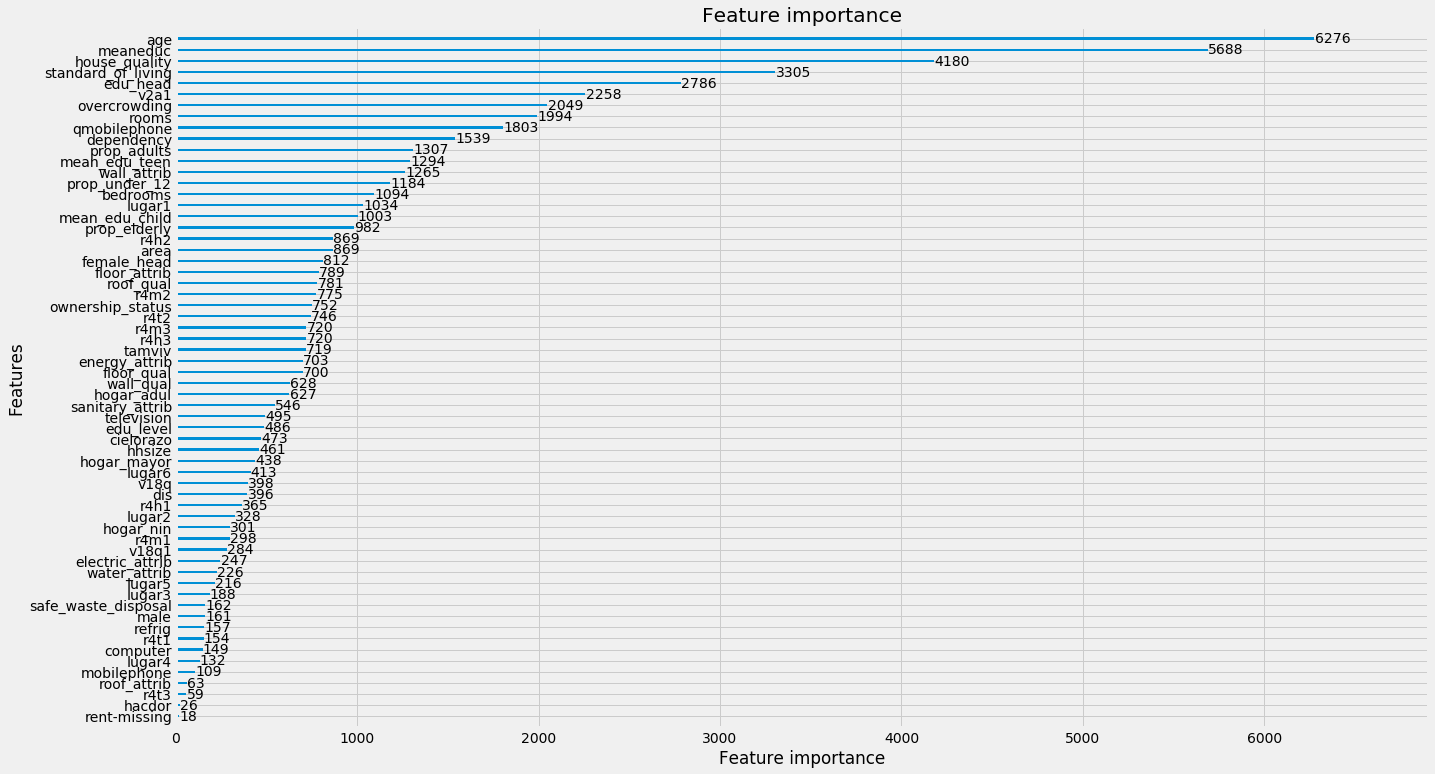

In [28]:
gbm.plot_importance(clf,figsize=((20,12)))
plt.show()

#### Lets proceed with our bayesian optimization and select the best paramters to improve our model.
#### lets set our parameter space with all the important parameters

In [207]:
#domain space
space = {
    'boosting_type': hp.choice('boosting_type', [{'boosting_type': 'gbdt', 'subsample': hp.uniform('gdbt_subsample', 0.5, 1)}, 
                                                 {'boosting_type': 'dart', 'subsample': hp.uniform('dart_subsample', 0.5, 1)},
                                                 {'boosting_type': 'goss', 'subsample': 1.0}]),
    'num_leaves': hp.quniform('num_leaves', 30, 150, 1),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
    'subsample_for_bin': hp.quniform('subsample_for_bin', 20000, 300000, 20000),
    'min_child_samples': hp.quniform('min_child_samples', 20, 500, 5),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.6, 1.0),
    'max_depth':hp.choice('max_depth',[4,6,8,10,12])
}

In [208]:
N_FOLDS=5
def gbm_objective(params, n_folds = N_FOLDS):
    """Objective function for Gradient Boosting Machine Hyperparameter Optimization"""
    y_bin = label_binarize(Y_resampled, classes=[1,2,3,4])
    n_classes = y_bin.shape[1]
    # Keep track of evals
    global ITERATION
    
    ITERATION += 1
    
    # Retrieve the subsample if present otherwise set to 1.0
    subsample = params['boosting_type'].get('subsample', 1.0)
    
    # Extract the boosting type
    params['boosting_type'] = params['boosting_type']['boosting_type']
    params['subsample'] = subsample
    
    # Make sure parameters that need to be integers are integers
    for parameter_name in ['num_leaves', 'subsample_for_bin', 'min_child_samples','max_depth']:
        params[parameter_name] = int(params[parameter_name])
    
    start = timer()
    
    clf = gbm.LGBMClassifier(**params,class_weight='balanced',n_estimators=1000,objective='multiclass',importance_type='gain')
    
    # Perform n_folds cross validation
    y_score = cross_val_predict(clf,X_resampled,Y_resampled,cv=5,method='predict_proba')
    
    run_time = timer() - start
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    roc_auc_score = np.mean(list(roc_auc.values()))
    
    loss = 1 - roc_auc_score
    
    
    # Dictionary with information for evaluation
    return {'loss': loss, 'params': params, 'iteration': ITERATION, 
            'train_time': run_time, 'status': STATUS_OK}
    

In [209]:
tpe_algorithm = tpe.suggest

In [210]:
gbm_bayes_trials = Trials()

In [211]:
%%capture

# Global variable
global  ITERATION

ITERATION = 0
MAX_EVALS = 100

# Run optimization
best = fmin(fn = gbm_objective, space = space, algo = tpe.suggest, 
            max_evals = MAX_EVALS, trials = gbm_bayes_trials, rstate = np.random.RandomState(50))

In [212]:
gbm_results = gbm_bayes_trials.results
#converting the results to dataframe
dt = sorted([{'loss':trial['loss'],'boosting_type':trial['params']['boosting_type'],'colsample':trial['params']['colsample_bytree'],'learning_rate':trial['params']['learning_rate'],'max_depth':trial['params']['max_depth'],\
             'min_child_samples':trial['params']['min_child_samples'],'num_leaves':trial['params']['num_leaves'],'reg_alpha':trial['params']['reg_alpha'],'reg_lambda':trial['params']['reg_lambda'],\
             'subsample_for_bin':trial['params']['subsample_for_bin'],'subsample':trial['params']['subsample'],'train_time':trial['train_time']} for trial in gbm_results],key=lambda x:(x['loss'],x['train_time']))
results = pd.DataFrame(dt)
results.head()

,boosting_type,colsample,learning_rate,loss,max_depth,min_child_samples,num_leaves,reg_alpha,reg_lambda,subsample,subsample_for_bin,train_time
0,gbdt,0.670900,0.055781,0.057601,12,20,132,0.567441,0.267562,0.815619,140000,108.090337
1,gbdt,0.676943,0.076778,0.057815,12,20,95,0.478492,0.622625,0.505945,260000,90.191379
2,gbdt,0.654344,0.094698,0.057905,12,20,149,0.555918,0.346095,0.671279,40000,83.380201
3,gbdt,0.728798,0.087665,0.059315,10,20,150,0.723145,0.128241,0.684960,40000,75.177751
4,gbdt,0.712540,0.086345,0.060514,10,20,143,0.910242,0.063768,0.696807,20000,79.715280


In [224]:
results.train_time.sum()/60

159.18711394275402

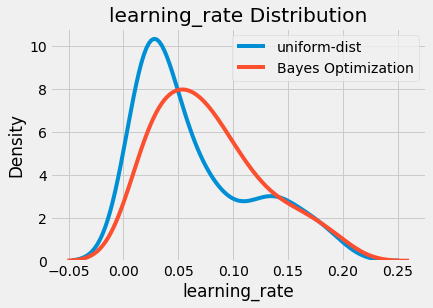

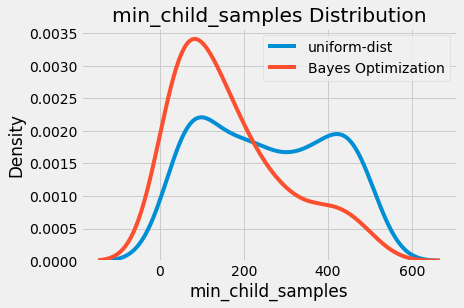

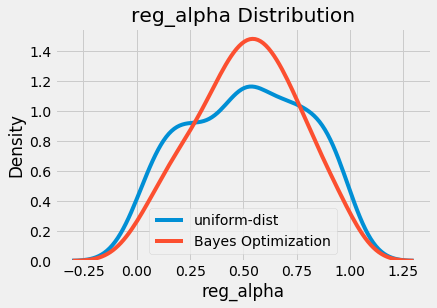

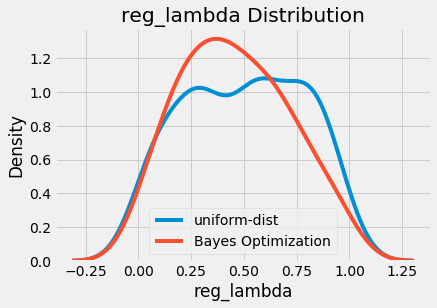

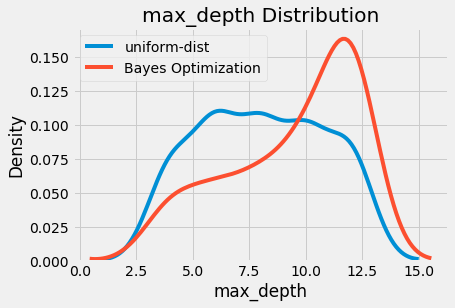

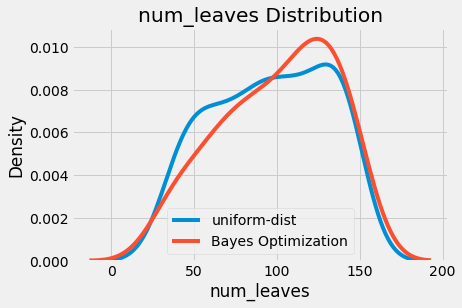

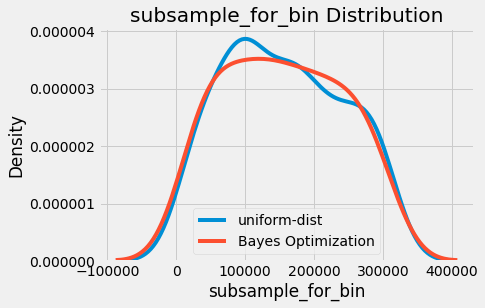

In [213]:
compare_distributions('learning_rate')
compare_distributions('min_child_samples')
compare_distributions('reg_alpha')
compare_distributions('reg_lambda')
compare_distributions('max_depth')
compare_distributions('num_leaves')
compare_distributions('subsample_for_bin')

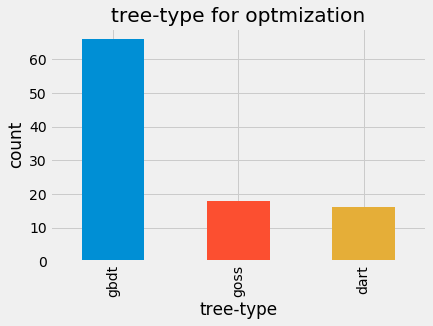

In [214]:
results['boosting_type'].value_counts().plot.bar()
plt.title('tree-type for optmization')
plt.xlabel('{}'.format('tree-type')); plt.ylabel('count');
plt.show();

#### lets use these hyper-parameter values and train our lgbm model and assess the results

In [215]:
dict(results.loc[0])

{'boosting_type': 'gbdt',
 'colsample': 0.6709002350313579,
 'learning_rate': 0.05578056207369407,
 'loss': 0.05760110855662792,
 'max_depth': 12,
 'min_child_samples': 20,
 'num_leaves': 132,
 'reg_alpha': 0.5674407583950459,
 'reg_lambda': 0.26756236587824017,
 'subsample': 0.8156188312476566,
 'subsample_for_bin': 140000,
 'train_time': 108.09033709633513}

In [216]:
y_bin = label_binarize(Y_resampled, classes=[1,2,3,4])
n_classes = y_bin.shape[1]
start = timer()

params=dict(results.loc[0])
    
clf = gbm.LGBMClassifier(**params,class_weight='balanced',n_estimators=500,objective='multiclass',importance_type='gain')
    
    # Perform n_folds cross validation
y_score = cross_val_predict(clf,X_resampled,Y_resampled,cv=5,method='predict_proba')
    
run_time = timer() - start
    
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
roc_auc_score = np.mean(list(roc_auc.values()))

mean_roc_score-- 0.9432900985062258


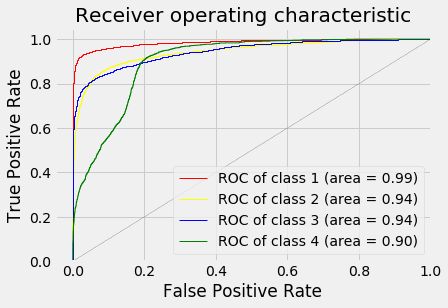

In [217]:
print('mean_roc_score--',roc_auc_score)
plot_ROC(fpr,tpr,4)

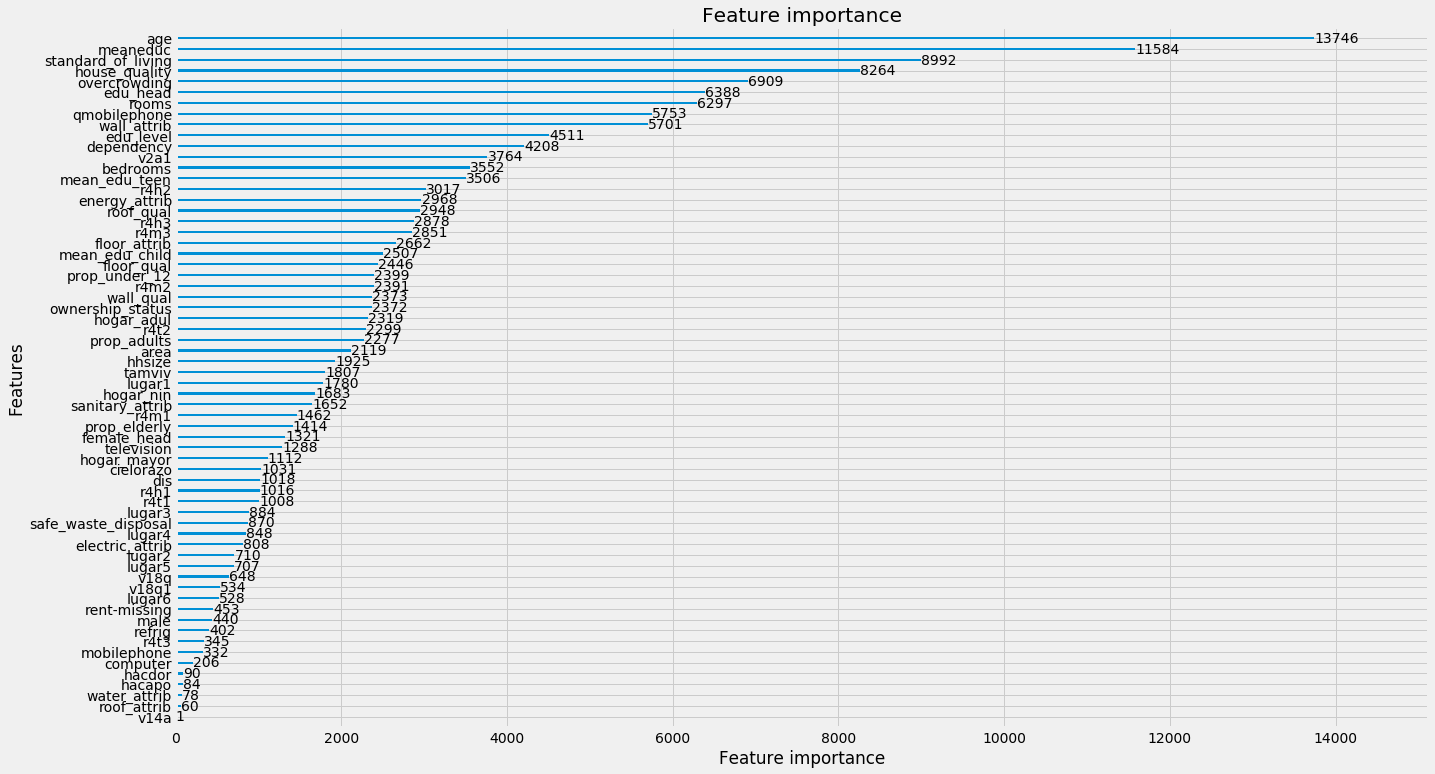

In [218]:
clf.fit(X_resampled,Y_resampled,feature_name=feature_names)
gbm.plot_importance(clf,figsize=((20,12)))
plt.show()

#### GBM and SVM have given similar ROC scores for our classes on cross validation.
#### As per the feature importance chart given by GBM,the engineered features have higher scores such as house quality and standard of living scores,even the ordinal columns which we created have fared better and have proven helpful in predicting our classes.
#### The final step would be to predict our test labels and submit them to help us assess the scores.

In [232]:
pred = clf.predict(test)

In [233]:
submissions['Target']=pred

In [234]:
submissions

,Target
Id,
ID_2f6873615,3
ID_1c78846d2,3
ID_e5442cf6a,3
ID_a8db26a79,1
ID_a62966799,2
ID_e77d38d45,2
ID_3c5f4bd51,2
ID_a849c29bd,2
ID_472fa82da,2
